In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv("drive/MyDrive/pca_reduced_dataset.csv")

In [2]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution:")
print(df['Churn'].value_counts())
print("\nPercentage distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)

Dataset shape: (7043, 15)

First 5 rows:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.826706 -1.373583 -1.230767 -0.087034  1.283266 -0.712259  0.129103   
1 -0.201515 -0.126850 -1.014370 -0.258006 -0.705918  0.652936 -0.216050   
2 -0.456477 -1.324500 -0.911066 -0.079200 -0.499640  0.499167 -0.566206   
3 -0.176442  0.380674 -1.888965 -0.769751 -0.064559  0.539682  0.187003   
4  0.014410 -1.833934  0.274640 -0.250129  0.332321 -0.552265 -0.254106   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  Churn  
0 -0.044028  0.123456  0.226739  0.257677  0.671813  0.579817  0.011222      0  
1  0.606991 -0.826557  0.098576 -0.548355 -0.388974 -0.362146  0.618746      0  
2 -0.012590  0.036379  0.973500  0.384069  0.314796 -0.042328  0.070555      1  
3  0.527100 -0.594101 -0.337365 -0.252536 -0.640810  0.017788  0.420809      0  
4 -0.130753  0.006342 -0.006539  0.255177 -0.173405 -0.516260  0.146374      1  

Dataset info:
<class 

In [3]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (5634, 14)
Test set size: (1409, 14)


In [4]:
rf_basic = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    class_weight='balanced'
)

print("Training Basic Random Forest...")
rf_basic.fit(X_train, y_train)

y_pred_basic = rf_basic.predict(X_test)
y_pred_proba_basic = rf_basic.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
precision_basic = precision_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic)
f1_basic = f1_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_pred_proba_basic)

print(f"\nPerformance Metrics (Basic Random Forest):")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"Recall: {recall_basic:.4f}")
print(f"F1-Score: {f1_basic:.4f}")
print(f"AUC-ROC: {auc_basic:.4f}")

Training Basic Random Forest...

Performance Metrics (Basic Random Forest):
Accuracy: 0.7828
Precision: 0.6318
Recall: 0.4358
F1-Score: 0.5158
AUC-ROC: 0.8099



 CONFUSION MATRIX - BASIC RANDOM FOREST:
[[940  95]
 [211 163]]


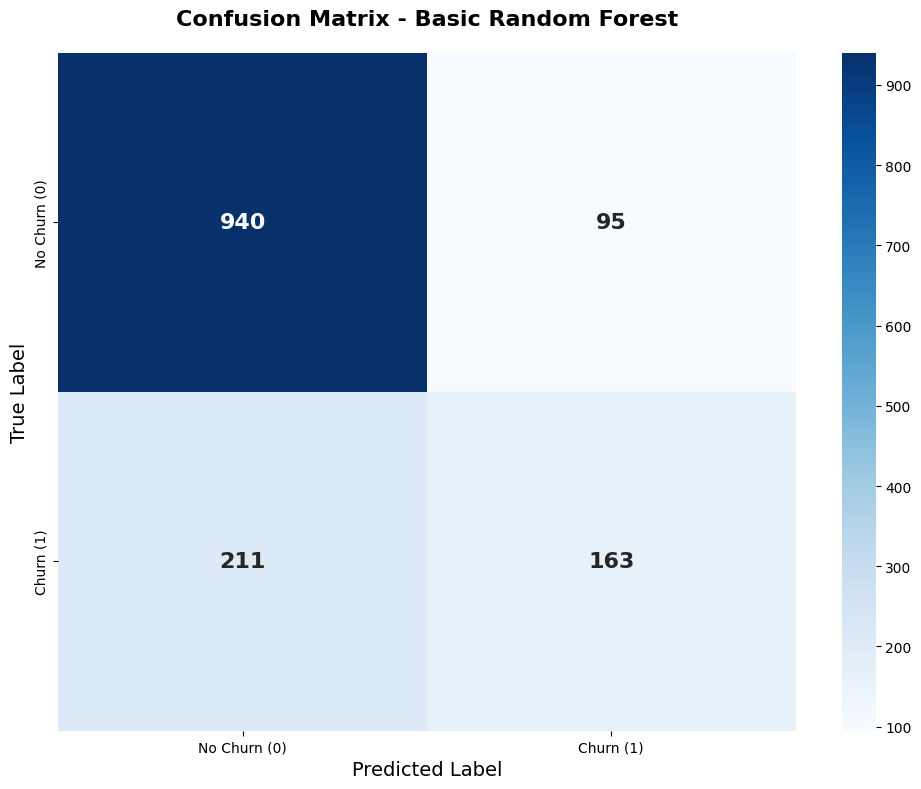

In [5]:
print(f"\n CONFUSION MATRIX - BASIC RANDOM FOREST:")
cm_basic = confusion_matrix(y_test, y_pred_basic)
print(cm_basic)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Basic Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
# Cross-validation
cv_scores_basic = cross_val_score(rf_basic, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_basic.mean():.4f} (+/- {cv_scores_basic.std() * 2:.4f})")

# Feature importance
feature_importance_basic = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_basic.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 5 Most Important PCA Components (Basic RF):")
print(feature_importance_basic.head(5))

Cross-validation Accuracy: 0.7828 (+/- 0.0166)

Top 5 Most Important PCA Components (Basic RF):
  Feature  Importance
1     PC2    0.212988
7     PC8    0.108647
0     PC1    0.097455
2     PC3    0.079083
8     PC9    0.055416


Variety 2 - GridSearchCV

In [7]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("Performing hyperparameter tuning with GridSearchCV...")
rf_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_tuned.fit(X_train, y_train)
print("Hyperparameter tuning completed!")

#best parameters found
print("\nBEST PARAMETERS FOUND:")
best_params = rf_tuned.best_params_
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"Best Cross-validation Score (F1): {rf_tuned.best_score_:.4f}")


Performing hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Hyperparameter tuning completed!

BEST PARAMETERS FOUND:
   class_weight: balanced_subsample
   max_depth: 10
   min_samples_leaf: 2
   min_samples_split: 2
   n_estimators: 50
Best Cross-validation Score (F1): 0.6297


In [8]:
best_rf_tuned = rf_tuned.best_estimator_

y_pred_tuned = best_rf_tuned.predict(X_test)
y_pred_proba_tuned = best_rf_tuned.predict_proba(X_test)[:, 1]

#performance metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\nPERFORMANCE METRICS - TUNED RANDOM FOREST:")
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")
print(f"AUC-ROC:   {auc_tuned:.4f}")


PERFORMANCE METRICS - TUNED RANDOM FOREST:
Accuracy:  0.7651
Precision: 0.5458
Recall:    0.6845
F1-Score:  0.6074
AUC-ROC:   0.8344


In [9]:
cv_scores_tuned = cross_val_score(best_rf_tuned, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_tuned.mean():.4f} (+/- {cv_scores_tuned.std() * 2:.4f})")


Cross-validation Accuracy: 0.7727 (+/- 0.0190)



CONFUSION MATRIX - TUNED RANDOM FOREST:
[[822 213]
 [118 256]]


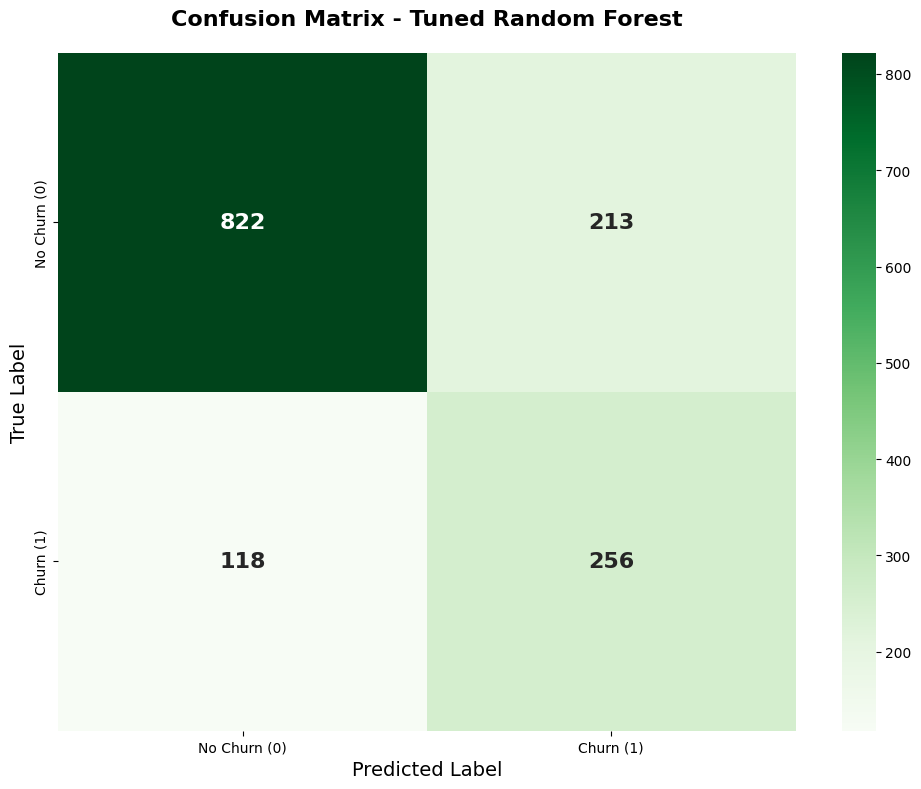

In [10]:
print("\nCONFUSION MATRIX - TUNED RANDOM FOREST:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print(cm_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Tuned Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
print("\nCLASSIFICATION REPORT - TUNED RANDOM FOREST:")
print(classification_report(y_test, y_pred_tuned, target_names=['No Churn', 'Churn']))


CLASSIFICATION REPORT - TUNED RANDOM FOREST:
              precision    recall  f1-score   support

    No Churn       0.87      0.79      0.83      1035
       Churn       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



In [13]:
try:
    improvement_auc = auc_tuned - auc_basic
    improvement_f1 = f1_tuned - f1_basic
    improvement_recall = recall_tuned - recall_basic

    print(f"\nPERFORMANCE IMPROVEMENT OVER BASIC MODEL:")
    print(f"AUC Improvement: {improvement_auc:+.4f}")
    print(f"F1-Score Improvement: {improvement_f1:+.4f}")
    print(f"Recall Improvement: {improvement_recall:+.4f}")

    if improvement_auc > 0:
        print("Tuning successfully improved model performance")
    else:
        print("Tuning did not improve performance significantly")

except NameError:
    print("\nBasic model not available for comparison")



PERFORMANCE IMPROVEMENT OVER BASIC MODEL:
AUC Improvement: +0.0245
F1-Score Improvement: +0.0915
Recall Improvement: +0.2487
Tuning successfully improved model performance


Variety 3 - Focused Random Forest(High recall)

In [14]:
#model with high recall configuration
rf_focused = RandomForestClassifier(
    random_state=42,
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight={0: 1, 1: 3},
    bootstrap=True,
    max_samples=0.8
)

print("Training Focused Random Forest (High Recall Configuration)...")
rf_focused.fit(X_train, y_train)
print("Training completed!")

y_pred_focused = rf_focused.predict(X_test)
y_pred_proba_focused = rf_focused.predict_proba(X_test)[:, 1]

Training Focused Random Forest (High Recall Configuration)...
Training completed!


In [15]:
accuracy_focused = accuracy_score(y_test, y_pred_focused)
precision_focused = precision_score(y_test, y_pred_focused)
recall_focused = recall_score(y_test, y_pred_focused)
f1_focused = f1_score(y_test, y_pred_focused)
auc_focused = roc_auc_score(y_test, y_pred_proba_focused)

print("\nPERFORMANCE METRICS - FOCUSED RANDOM FOREST (HIGH RECALL):")
print(f"Accuracy:  {accuracy_focused:.4f}")
print(f"Precision: {precision_focused:.4f}")
print(f"Recall:    {recall_focused:.4f}")
print(f"F1-Score:  {f1_focused:.4f}")
print(f"AUC-ROC:   {auc_focused:.4f}")


PERFORMANCE METRICS - FOCUSED RANDOM FOREST (HIGH RECALL):
Accuracy:  0.7779
Precision: 0.5818
Recall:    0.5802
F1-Score:  0.5810
AUC-ROC:   0.8267


In [16]:
cv_scores_focused = cross_val_score(rf_focused, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores_focused.mean():.4f} (+/- {cv_scores_focused.std() * 2:.4f})")

Cross-validation Accuracy: 0.7916 (+/- 0.0167)


[[879 156]
 [157 217]]


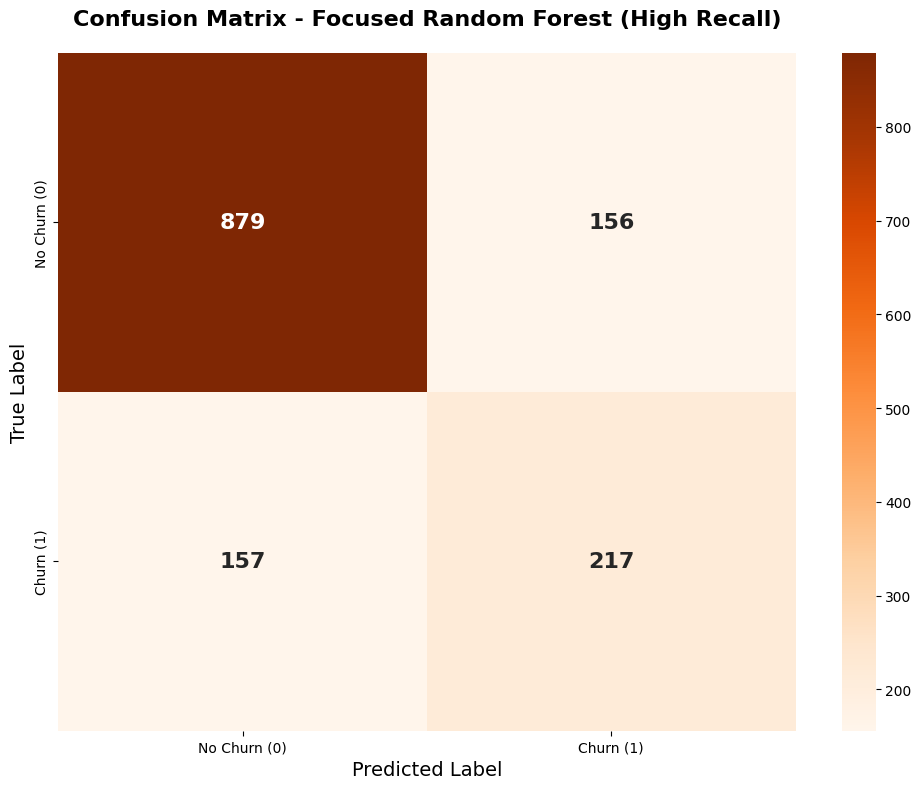

In [17]:
cm_focused = confusion_matrix(y_test, y_pred_focused)
print(cm_focused)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_focused, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Focused Random Forest (High Recall)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
tn_focused, fp_focused, fn_focused, tp_focused = cm_focused.ravel()
specificity_focused = tn_focused / (tn_focused + fp_focused)
false_positive_rate_focused = fp_focused / (fp_focused + tn_focused)

print("Confusion Matrix Analysis:")
print(f"True Negatives: {tn_focused}")
print(f"False Positives: {fp_focused}")
print(f"False Negatives: {fn_focused}")
print(f"True Positives: {tp_focused}")
print(f"Specificity: {specificity_focused:.4f}")
print(f"False Positive Rate: {false_positive_rate_focused:.4f}")
print(f"Sensitivity/Recall: {recall_focused:.4f}")

Confusion Matrix Analysis:
True Negatives: 879
False Positives: 156
False Negatives: 157
True Positives: 217
Specificity: 0.8493
False Positive Rate: 0.1507
Sensitivity/Recall: 0.5802


In [19]:
print("\nCLASSIFICATION REPORT - FOCUSED RANDOM FOREST:")
print(classification_report(y_test, y_pred_focused, target_names=['No Churn', 'Churn']))


CLASSIFICATION REPORT - FOCUSED RANDOM FOREST:
              precision    recall  f1-score   support

    No Churn       0.85      0.85      0.85      1035
       Churn       0.58      0.58      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [20]:
# Analyze different threshold points with emphasis on recall
thresholds_to_test_high_recall = [0.2, 0.3, 0.4, 0.5, 0.6]
print("Performance at different thresholds (High Recall Focus):")
print("Threshold | Precision | Recall | F1-Score | Business Impact")

for threshold in thresholds_to_test_high_recall:
    y_pred_threshold = (y_pred_proba_focused >= threshold).astype(int)
    precision_th = precision_score(y_test, y_pred_threshold)
    recall_th = recall_score(y_test, y_pred_threshold)
    f1_th = f1_score(y_test, y_pred_threshold)

    # Business impact assessment
    if recall_th >= 0.8:
        impact = "Excellent - Catches most churners"
    elif recall_th >= 0.7:
        impact = "Good - Good churn detection"
    elif recall_th >= 0.6:
        impact = "Moderate - Reasonable detection"
    else:
        impact = "Poor - Misses many churners"

    print(f"{threshold:9.1f} | {precision_th:9.4f} | {recall_th:6.4f} | {f1_th:8.4f} | {impact}")


Performance at different thresholds (High Recall Focus):
Threshold | Precision | Recall | F1-Score | Business Impact
      0.2 |    0.4394 | 0.9011 |   0.5907 | Excellent - Catches most churners
      0.3 |    0.4848 | 0.8075 |   0.6058 | Excellent - Catches most churners
      0.4 |    0.5307 | 0.6925 |   0.6009 | Moderate - Reasonable detection
      0.5 |    0.5818 | 0.5802 |   0.5810 | Poor - Misses many churners
      0.6 |    0.6423 | 0.4706 |   0.5432 | Poor - Misses many churners


In [21]:
try:
    print("Recall Comparison:")
    print(f"Focused RF Recall: {recall_focused:.4f}")
    print(f"Tuned RF Recall: {recall_tuned:.4f}")
    print(f"Basic RF Recall: {recall_basic:.4f}")

    recall_improvement = recall_focused - recall_tuned
    print(f"Recall improvement over tuned model: {recall_improvement:+.4f}")

    if recall_improvement > 0:
        print("High recall strategy successfully increased recall")
    else:
        print("High recall strategy did not significantly increase recall")

except NameError:
    print("Other model variants not available for comparison")


Recall Comparison:
Focused RF Recall: 0.5802
Tuned RF Recall: 0.6845
Basic RF Recall: 0.4358
Recall improvement over tuned model: -0.1043
High recall strategy did not significantly increase recall


In [22]:
comparison_data = {
    'Model': ['Basic Random Forest', 'Hyperparameter-Tuned RF', 'Focused RF (High Recall)'],
    'Accuracy': [accuracy_basic, accuracy_tuned, accuracy_focused],
    'Precision': [precision_basic, precision_tuned, precision_focused],
    'Recall': [recall_basic, recall_tuned, recall_focused],
    'F1-Score': [f1_basic, f1_tuned, f1_focused],
    'AUC-ROC': [auc_basic, auc_tuned, auc_focused],
    'CV_Accuracy': [cv_scores_basic.mean(), cv_scores_tuned.mean(), cv_scores_focused.mean()],
    'CV_Std': [cv_scores_basic.std(), cv_scores_tuned.std(), cv_scores_focused.std()]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison Across All Varieties:")
print(comparison_df.round(4))

# Find best model based on F1-Score (balanced metric)
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\nBest Model: {best_model} (F1-Score: {best_f1:.4f})")


Performance Comparison Across All Varieties:
                      Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0       Basic Random Forest    0.7828     0.6318  0.4358    0.5158   0.8099   
1   Hyperparameter-Tuned RF    0.7651     0.5458  0.6845    0.6074   0.8344   
2  Focused RF (High Recall)    0.7779     0.5818  0.5802    0.5810   0.8267   

   CV_Accuracy  CV_Std  
0       0.7828  0.0083  
1       0.7727  0.0095  
2       0.7916  0.0084  

Best Model: Hyperparameter-Tuned RF (F1-Score: 0.6074)


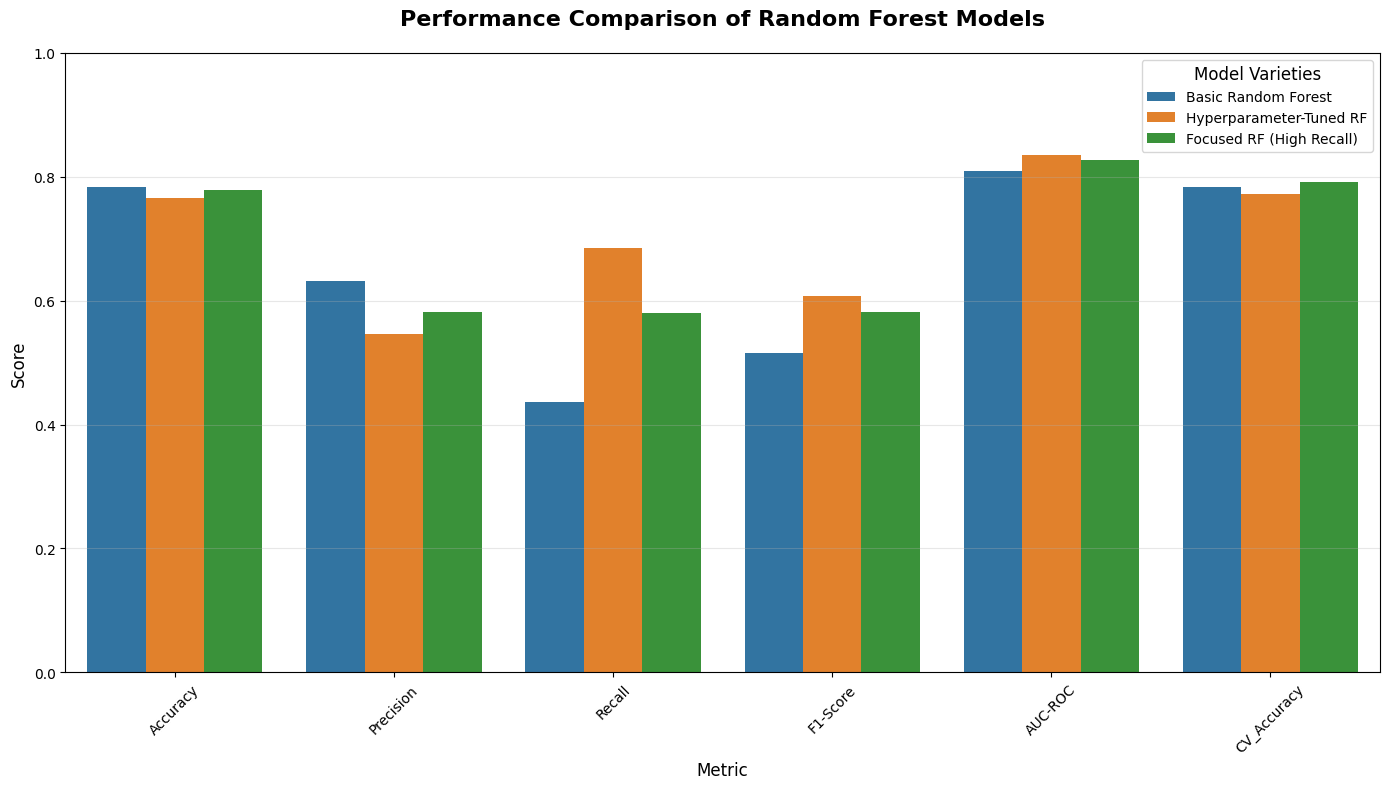


Performance Comparison Table:
                      Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0       Basic Random Forest    0.7828     0.6318  0.4358    0.5158   0.8099   
1   Hyperparameter-Tuned RF    0.7651     0.5458  0.6845    0.6074   0.8344   
2  Focused RF (High Recall)    0.7779     0.5818  0.5802    0.5810   0.8267   

   CV_Accuracy  CV_Std  
0       0.7828  0.0083  
1       0.7727  0.0095  
2       0.7916  0.0084  

Best Overall Model: Hyperparameter-Tuned RF (F1-Score: 0.6074)


In [23]:
comparison_melted = comparison_df.melt(
    'Model',
    var_name='Metric',
    value_name='Score',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'CV_Accuracy']
)

plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Performance Comparison of Random Forest Models', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1)  # Metrics are typically between 0 and 1
plt.legend(title='Model Varieties', title_fontsize=12, fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the comparison table again for reference
print("\nPerformance Comparison Table:")
print(comparison_df.round(4))

print(f"\nBest Overall Model: {best_model} (F1-Score: {best_f1:.4f})")